## Random Forest Model

In [36]:
import pandas as pd
import numpy as np

In [37]:
df = pd.read_csv('../../Dataset/gurgaon_properties_post_feature_selection_v2.csv')

In [38]:
df.head()

,property_type,sector,price,bedRoom,bathroom,balcony,agePossession,built_up_area,servant room,store room,furnishing_type,luxury_category,floor_category
0,flat,sector 36,0.82,3.0,2.0,2,New Property,850.0,0.0,0.0,0.0,Low,Low Floor
1,flat,sector 89,0.95,2.0,2.0,2,New Property,1226.0,1.0,0.0,0.0,Low,Mid Floor
2,flat,sohna road,0.32,2.0,2.0,1,New Property,1000.0,0.0,0.0,0.0,Low,High Floor
3,flat,sector 92,1.60,3.0,4.0,3+,Relatively New,1615.0,1.0,0.0,1.0,High,Mid Floor
4,flat,sector 102,0.48,2.0,2.0,1,Relatively New,582.0,0.0,1.0,0.0,High,Mid Floor


In [39]:
df.shape

(3554, 13)

In [40]:
df.head()

,property_type,sector,price,bedRoom,bathroom,balcony,agePossession,built_up_area,servant room,store room,furnishing_type,luxury_category,floor_category
0,flat,sector 36,0.82,3.0,2.0,2,New Property,850.0,0.0,0.0,0.0,Low,Low Floor
1,flat,sector 89,0.95,2.0,2.0,2,New Property,1226.0,1.0,0.0,0.0,Low,Mid Floor
2,flat,sohna road,0.32,2.0,2.0,1,New Property,1000.0,0.0,0.0,0.0,Low,High Floor
3,flat,sector 92,1.60,3.0,4.0,3+,Relatively New,1615.0,1.0,0.0,1.0,High,Mid Floor
4,flat,sector 102,0.48,2.0,2.0,1,Relatively New,582.0,0.0,1.0,0.0,High,Mid Floor


In [41]:
# 0 -> unfurnished
# 1 -> semifurnished
# 2 -> furnished
df['furnishing_type'] = df['furnishing_type'].replace({0.0:'unfurnished',1.0:'semifurnished',2.0:'furnished'})

In [42]:
X = df.drop(columns=['price'])
y = df['price']

In [43]:
# Applying the log1p transformation to the target variable
y_transformed = np.log1p(y)

In [15]:
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
import category_encoders as ce
import numpy as np

# Columns
columns_to_encode = ['property_type', 'sector', 'balcony', 'furnishing_type', 'luxury_category', 'floor_category']

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['bedRoom', 'bathroom', 'built_up_area', 'servant room', 'store room']),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), ['property_type', 'balcony', 'furnishing_type', 'luxury_category', 'floor_category']),
        ('target_enc', ce.TargetEncoder(), ['sector'])
    ],
    remainder='drop'
)

# Pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Hyperparameter grid (wider + balanced)
param_dist = {
    'regressor__n_estimators': [100, 200, 300, 400, 500],
    'regressor__max_depth': [10, 20, 30, 40, None],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4],
    'regressor__max_features': ['sqrt', 'log2', None],
    'regressor__bootstrap': [True, False]
}

# KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=50,               # try 50 random combinations
    cv=kfold,
    scoring='r2',
    n_jobs=-1,
    verbose=3,
    random_state=42
)

# Fit
random_search.fit(X, np.log1p(y))

# Best estimator & params
final_model = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)
print("Best R2 Score:", random_search.best_score_)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'regressor__n_estimators': 400, 'regressor__min_samples_split': 5, 'regressor__min_samples_leaf': 1, 'regressor__max_features': None, 'regressor__max_depth': 20, 'regressor__bootstrap': True}
Best R2 Score: 0.8913880681352294


In [17]:
!pip install optuna


   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ---- ----------------------------------- 0.3/2.1 MB ? eta -:--:--
   --------- ------------------------------ 0.5/2.1 MB 1.1 MB/s eta 0:00:02
   -------------- ------------------------- 0.8/2.1 MB 958.5 kB/s eta 0:00:02
   -------------- ------------------------- 0.8/2.1 MB 958.5 kB/s eta 0:00:02
   ------------------- -------------------- 1.0/2.1 MB 968.5 kB/s eta 0:00:02
   ------------------------ --------------- 1.3/2.1 MB 1.0 MB/s eta 0:00:01
   ----------------------------- ---------- 1.6/2.1 MB 1.0 MB/s eta 0:00:01
   ---------------------------------- ----- 1.8/2.1 MB 1.0 MB/s eta 0:00:01
   ---------------------------------------- 2.1/2.1 MB 1.1 MB/s  0:00:02

   ---------------------------------------- 0/6 [Mako]
   ---------------------------------------- 0/6 [Mako]
   ---------------------------------------- 0/6 [Mako]
   -------------

In [18]:
import optuna
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import category_encoders as ce
import numpy as np

# ==========================
# 1️⃣ Preprocessing pipeline
# ==========================

columns_to_encode = ['property_type', 'sector', 'balcony', 'furnishing_type', 'luxury_category', 'floor_category']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['bedRoom', 'bathroom', 'built_up_area', 'servant room', 'store room']),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), 
         ['property_type', 'balcony', 'furnishing_type', 'luxury_category', 'floor_category']),
        ('target_enc', ce.TargetEncoder(), ['sector'])
    ],
    remainder='drop'
)

# ==========================================================
# 2️⃣ Define Objective Function for Optuna Optimization
# ==========================================================
def objective(trial):
    # Suggest hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 100, 600)
    max_depth = trial.suggest_int('max_depth', 5, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])
    
    # Build pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            max_features=max_features,
            bootstrap=bootstrap,
            random_state=42,
            n_jobs=-1
        ))
    ])
    
    # KFold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, X, np.log1p(y), cv=kf, scoring='r2', n_jobs=-1)
    
    # Return mean CV R² score
    return np.mean(scores)

# =================================
# 3️⃣ Run the Optuna Optimization
# =================================
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar=True)  # you can increase n_trials to 100+ for best tuning

# ================================
# 4️⃣ Display Best Results
# ================================
print("✅ Best R² Score:", study.best_value)
print("🏆 Best Parameters:")
for key, value in study.best_params.items():
    print(f"   {key}: {value}")

# ================================
# 5️⃣ Train Final Model with Best Params
# ================================
best_params = study.best_params
final_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(**best_params, random_state=42, n_jobs=-1))
])

final_model.fit(X, np.log1p(y))
print("🎯 Final model trained successfully!")


d:\Real-Estate-Insights-Platform\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-10-08 12:37:23,934] A new study created in memory with name: no-name-2a67a0a6-56f9-44cc-b915-42b0563c92dd
Best trial: 0. Best value: 0.889161:   2%|▏         | 1/50 [00:01<01:16,  1.55s/it]

[I 2025-10-08 12:37:25,486] Trial 0 finished with value: 0.8891614493438407 and parameters: {'n_estimators': 300, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': None, 'bootstrap': True}. Best is trial 0 with value: 0.8891614493438407.


Best trial: 0. Best value: 0.889161:   4%|▍         | 2/50 [00:02<00:59,  1.25s/it]

[I 2025-10-08 12:37:26,524] Trial 1 finished with value: 0.8794333630284499 and parameters: {'n_estimators': 469, 'max_depth': 23, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.8891614493438407.


Best trial: 0. Best value: 0.889161:   6%|▌         | 3/50 [00:03<00:47,  1.00s/it]

[I 2025-10-08 12:37:27,235] Trial 2 finished with value: 0.8717424380962019 and parameters: {'n_estimators': 343, 'max_depth': 21, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_features': 'log2', 'bootstrap': True}. Best is trial 0 with value: 0.8891614493438407.


Best trial: 0. Best value: 0.889161:   8%|▊         | 4/50 [00:04<00:52,  1.14s/it]

[I 2025-10-08 12:37:28,587] Trial 3 finished with value: 0.8826238069621877 and parameters: {'n_estimators': 581, 'max_depth': 38, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 'log2', 'bootstrap': False}. Best is trial 0 with value: 0.8891614493438407.


Best trial: 0. Best value: 0.889161:  10%|█         | 5/50 [00:05<00:41,  1.09it/s]

[I 2025-10-08 12:37:29,105] Trial 4 finished with value: 0.884704622834899 and parameters: {'n_estimators': 110, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': None, 'bootstrap': True}. Best is trial 0 with value: 0.8891614493438407.


Best trial: 0. Best value: 0.889161:  12%|█▏        | 6/50 [00:06<00:49,  1.12s/it]

[I 2025-10-08 12:37:30,628] Trial 5 finished with value: 0.8867741917855753 and parameters: {'n_estimators': 438, 'max_depth': 33, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 0 with value: 0.8891614493438407.


Best trial: 0. Best value: 0.889161:  14%|█▍        | 7/50 [00:08<00:57,  1.33s/it]

[I 2025-10-08 12:37:32,390] Trial 6 finished with value: 0.8878206968853728 and parameters: {'n_estimators': 416, 'max_depth': 12, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': None, 'bootstrap': True}. Best is trial 0 with value: 0.8891614493438407.


Best trial: 0. Best value: 0.889161:  16%|█▌        | 8/50 [00:09<00:56,  1.34s/it]

[I 2025-10-08 12:37:33,752] Trial 7 finished with value: 0.8813263358244148 and parameters: {'n_estimators': 556, 'max_depth': 28, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True}. Best is trial 0 with value: 0.8891614493438407.


Best trial: 0. Best value: 0.889161:  18%|█▊        | 9/50 [00:10<00:41,  1.01s/it]

[I 2025-10-08 12:37:34,027] Trial 8 finished with value: 0.871769112403142 and parameters: {'n_estimators': 105, 'max_depth': 38, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 0.8891614493438407.


Best trial: 0. Best value: 0.889161:  20%|██        | 10/50 [00:10<00:38,  1.03it/s]

[I 2025-10-08 12:37:34,901] Trial 9 finished with value: 0.8744835625785907 and parameters: {'n_estimators': 443, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 0 with value: 0.8891614493438407.


Best trial: 0. Best value: 0.889161:  22%|██▏       | 11/50 [00:13<00:55,  1.42s/it]

[I 2025-10-08 12:37:37,337] Trial 10 finished with value: 0.8192384328773363 and parameters: {'n_estimators': 241, 'max_depth': 47, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': False}. Best is trial 0 with value: 0.8891614493438407.


Best trial: 0. Best value: 0.889161:  24%|██▍       | 12/50 [00:14<00:53,  1.41s/it]

[I 2025-10-08 12:37:38,720] Trial 11 finished with value: 0.8877949071910857 and parameters: {'n_estimators': 302, 'max_depth': 16, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': None, 'bootstrap': True}. Best is trial 0 with value: 0.8891614493438407.


Best trial: 0. Best value: 0.889161:  26%|██▌       | 13/50 [00:15<00:44,  1.20s/it]

[I 2025-10-08 12:37:39,454] Trial 12 finished with value: 0.8578483129386191 and parameters: {'n_estimators': 233, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': True}. Best is trial 0 with value: 0.8891614493438407.


Best trial: 13. Best value: 0.89042:  28%|██▊       | 14/50 [00:17<00:56,  1.56s/it]

[I 2025-10-08 12:37:41,827] Trial 13 finished with value: 0.8904196969966132 and parameters: {'n_estimators': 380, 'max_depth': 18, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': True}. Best is trial 13 with value: 0.8904196969966132.


Best trial: 14. Best value: 0.89061:  30%|███       | 15/50 [00:19<00:58,  1.66s/it]

[I 2025-10-08 12:37:43,741] Trial 14 finished with value: 0.890609967226073 and parameters: {'n_estimators': 253, 'max_depth': 19, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': True}. Best is trial 14 with value: 0.890609967226073.


Best trial: 14. Best value: 0.89061:  32%|███▏      | 16/50 [00:21<00:53,  1.58s/it]

[I 2025-10-08 12:37:45,113] Trial 15 finished with value: 0.8901501217773177 and parameters: {'n_estimators': 182, 'max_depth': 28, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': True}. Best is trial 14 with value: 0.890609967226073.


Best trial: 16. Best value: 0.891185:  34%|███▍      | 17/50 [00:24<01:04,  1.96s/it]

[I 2025-10-08 12:37:47,969] Trial 16 finished with value: 0.8911850968852264 and parameters: {'n_estimators': 373, 'max_depth': 24, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': True}. Best is trial 16 with value: 0.8911850968852264.


Best trial: 17. Best value: 0.891548:  36%|███▌      | 18/50 [00:28<01:23,  2.61s/it]

[I 2025-10-08 12:37:52,085] Trial 17 finished with value: 0.8915481051326648 and parameters: {'n_estimators': 512, 'max_depth': 34, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': True}. Best is trial 17 with value: 0.8915481051326648.


Best trial: 17. Best value: 0.891548:  38%|███▊      | 19/50 [00:33<01:50,  3.57s/it]

[I 2025-10-08 12:37:57,877] Trial 18 finished with value: 0.8196326085937329 and parameters: {'n_estimators': 509, 'max_depth': 50, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': False}. Best is trial 17 with value: 0.8915481051326648.


Best trial: 17. Best value: 0.891548:  40%|████      | 20/50 [00:36<01:33,  3.12s/it]

[I 2025-10-08 12:37:59,975] Trial 19 finished with value: 0.8839222380336199 and parameters: {'n_estimators': 522, 'max_depth': 35, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True}. Best is trial 17 with value: 0.8915481051326648.


Best trial: 17. Best value: 0.891548:  42%|████▏     | 21/50 [00:38<01:28,  3.07s/it]

[I 2025-10-08 12:38:02,901] Trial 20 finished with value: 0.8912157895811716 and parameters: {'n_estimators': 377, 'max_depth': 32, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': True}. Best is trial 17 with value: 0.8915481051326648.


Best trial: 17. Best value: 0.891548:  44%|████▍     | 22/50 [00:41<01:23,  2.98s/it]

[I 2025-10-08 12:38:05,693] Trial 21 finished with value: 0.8910803374562694 and parameters: {'n_estimators': 356, 'max_depth': 32, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': True}. Best is trial 17 with value: 0.8915481051326648.


Best trial: 22. Best value: 0.891608:  46%|████▌     | 23/50 [00:45<01:24,  3.14s/it]

[I 2025-10-08 12:38:09,195] Trial 22 finished with value: 0.8916080942516154 and parameters: {'n_estimators': 394, 'max_depth': 43, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': True}. Best is trial 22 with value: 0.8916080942516154.


Best trial: 23. Best value: 0.891712:  48%|████▊     | 24/50 [00:49<01:30,  3.48s/it]

[I 2025-10-08 12:38:13,455] Trial 23 finished with value: 0.8917122117751237 and parameters: {'n_estimators': 488, 'max_depth': 43, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': True}. Best is trial 23 with value: 0.8917122117751237.


Best trial: 23. Best value: 0.891712:  50%|█████     | 25/50 [00:53<01:27,  3.51s/it]

[I 2025-10-08 12:38:17,051] Trial 24 finished with value: 0.8910735900382191 and parameters: {'n_estimators': 483, 'max_depth': 46, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': True}. Best is trial 23 with value: 0.8917122117751237.


Best trial: 25. Best value: 0.891763:  52%|█████▏    | 26/50 [00:57<01:33,  3.90s/it]

[I 2025-10-08 12:38:21,866] Trial 25 finished with value: 0.8917630790209475 and parameters: {'n_estimators': 539, 'max_depth': 42, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': True}. Best is trial 25 with value: 0.8917630790209475.


Best trial: 25. Best value: 0.891763:  54%|█████▍    | 27/50 [01:03<01:42,  4.47s/it]

[I 2025-10-08 12:38:27,651] Trial 26 finished with value: 0.8253853064855416 and parameters: {'n_estimators': 556, 'max_depth': 42, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': False}. Best is trial 25 with value: 0.8917630790209475.


Best trial: 27. Best value: 0.891801:  56%|█████▌    | 28/50 [01:09<01:45,  4.78s/it]

[I 2025-10-08 12:38:33,151] Trial 27 finished with value: 0.8918006852657181 and parameters: {'n_estimators': 596, 'max_depth': 42, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': True}. Best is trial 27 with value: 0.8918006852657181.


Best trial: 27. Best value: 0.891801:  58%|█████▊    | 29/50 [01:12<01:28,  4.19s/it]

[I 2025-10-08 12:38:35,982] Trial 28 finished with value: 0.8854032644118526 and parameters: {'n_estimators': 597, 'max_depth': 41, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 27 with value: 0.8918006852657181.


Best trial: 27. Best value: 0.891801:  60%|██████    | 30/50 [01:13<01:08,  3.42s/it]

[I 2025-10-08 12:38:37,605] Trial 29 finished with value: 0.874594639976624 and parameters: {'n_estimators': 556, 'max_depth': 49, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': True}. Best is trial 27 with value: 0.8918006852657181.


Best trial: 27. Best value: 0.891801:  62%|██████▏   | 31/50 [01:18<01:11,  3.76s/it]

[I 2025-10-08 12:38:42,138] Trial 30 finished with value: 0.8910361810538407 and parameters: {'n_estimators': 598, 'max_depth': 45, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': True}. Best is trial 27 with value: 0.8918006852657181.


Best trial: 27. Best value: 0.891801:  64%|██████▍   | 32/50 [01:22<01:10,  3.92s/it]

[I 2025-10-08 12:38:46,447] Trial 31 finished with value: 0.8916927192759541 and parameters: {'n_estimators': 482, 'max_depth': 42, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': True}. Best is trial 27 with value: 0.8918006852657181.


Best trial: 27. Best value: 0.891801:  66%|██████▌   | 33/50 [01:27<01:09,  4.11s/it]

[I 2025-10-08 12:38:50,987] Trial 32 finished with value: 0.8916703074241642 and parameters: {'n_estimators': 477, 'max_depth': 39, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': True}. Best is trial 27 with value: 0.8918006852657181.


Best trial: 27. Best value: 0.891801:  68%|██████▊   | 34/50 [01:31<01:07,  4.22s/it]

[I 2025-10-08 12:38:55,462] Trial 33 finished with value: 0.8915460443638901 and parameters: {'n_estimators': 532, 'max_depth': 44, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': True}. Best is trial 27 with value: 0.8918006852657181.


Best trial: 27. Best value: 0.891801:  70%|███████   | 35/50 [01:36<01:06,  4.42s/it]

[I 2025-10-08 12:39:00,357] Trial 34 finished with value: 0.8254286412299514 and parameters: {'n_estimators': 455, 'max_depth': 40, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': False}. Best is trial 27 with value: 0.8918006852657181.


Best trial: 27. Best value: 0.891801:  72%|███████▏  | 36/50 [01:41<01:02,  4.48s/it]

[I 2025-10-08 12:39:04,985] Trial 35 finished with value: 0.891705098536981 and parameters: {'n_estimators': 497, 'max_depth': 36, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': True}. Best is trial 27 with value: 0.8918006852657181.


Best trial: 27. Best value: 0.891801:  74%|███████▍  | 37/50 [01:43<00:48,  3.73s/it]

[I 2025-10-08 12:39:06,956] Trial 36 finished with value: 0.8810513284983068 and parameters: {'n_estimators': 563, 'max_depth': 36, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True}. Best is trial 27 with value: 0.8918006852657181.


Best trial: 27. Best value: 0.891801:  76%|███████▌  | 38/50 [01:45<00:38,  3.25s/it]

[I 2025-10-08 12:39:09,072] Trial 37 finished with value: 0.8800955072493464 and parameters: {'n_estimators': 540, 'max_depth': 37, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 27 with value: 0.8918006852657181.


Best trial: 27. Best value: 0.891801:  78%|███████▊  | 39/50 [01:48<00:36,  3.33s/it]

[I 2025-10-08 12:39:12,611] Trial 38 finished with value: 0.8911099444535664 and parameters: {'n_estimators': 418, 'max_depth': 30, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': True}. Best is trial 27 with value: 0.8918006852657181.


Best trial: 27. Best value: 0.891801:  80%|████████  | 40/50 [01:50<00:29,  2.98s/it]

[I 2025-10-08 12:39:14,755] Trial 39 finished with value: 0.8848008184941107 and parameters: {'n_estimators': 506, 'max_depth': 48, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True}. Best is trial 27 with value: 0.8918006852657181.


Best trial: 27. Best value: 0.891801:  82%|████████▏ | 41/50 [01:52<00:23,  2.63s/it]

[I 2025-10-08 12:39:16,570] Trial 40 finished with value: 0.8719320181785208 and parameters: {'n_estimators': 577, 'max_depth': 25, 'min_samples_split': 4, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 27 with value: 0.8918006852657181.


Best trial: 27. Best value: 0.891801:  84%|████████▍ | 42/50 [01:57<00:26,  3.26s/it]

[I 2025-10-08 12:39:21,292] Trial 41 finished with value: 0.8917228391123688 and parameters: {'n_estimators': 489, 'max_depth': 42, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': True}. Best is trial 27 with value: 0.8918006852657181.


Best trial: 27. Best value: 0.891801:  86%|████████▌ | 43/50 [02:01<00:25,  3.67s/it]

[I 2025-10-08 12:39:25,913] Trial 42 finished with value: 0.8917080289564364 and parameters: {'n_estimators': 498, 'max_depth': 39, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': True}. Best is trial 27 with value: 0.8918006852657181.


Best trial: 43. Best value: 0.892011:  88%|████████▊ | 44/50 [02:06<00:23,  3.97s/it]

[I 2025-10-08 12:39:30,599] Trial 43 finished with value: 0.892010945276871 and parameters: {'n_estimators': 454, 'max_depth': 39, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': True}. Best is trial 43 with value: 0.892010945276871.


Best trial: 43. Best value: 0.892011:  90%|█████████ | 45/50 [02:11<00:20,  4.12s/it]

[I 2025-10-08 12:39:35,080] Trial 44 finished with value: 0.8918603196598027 and parameters: {'n_estimators': 427, 'max_depth': 46, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': True}. Best is trial 43 with value: 0.892010945276871.


Best trial: 43. Best value: 0.892011:  92%|█████████▏| 46/50 [02:14<00:15,  3.88s/it]

[I 2025-10-08 12:39:38,373] Trial 45 finished with value: 0.8894781557452699 and parameters: {'n_estimators': 456, 'max_depth': 46, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': None, 'bootstrap': True}. Best is trial 43 with value: 0.892010945276871.


Best trial: 43. Best value: 0.892011:  94%|█████████▍| 47/50 [02:20<00:13,  4.60s/it]

[I 2025-10-08 12:39:44,651] Trial 46 finished with value: 0.8192304427046835 and parameters: {'n_estimators': 424, 'max_depth': 48, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': False}. Best is trial 43 with value: 0.892010945276871.


Best trial: 43. Best value: 0.892011:  96%|█████████▌| 48/50 [02:23<00:08,  4.14s/it]

[I 2025-10-08 12:39:47,719] Trial 47 finished with value: 0.8908607929124035 and parameters: {'n_estimators': 338, 'max_depth': 45, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': True}. Best is trial 43 with value: 0.892010945276871.


Best trial: 43. Best value: 0.892011:  98%|█████████▊| 49/50 [02:27<00:04,  4.05s/it]

[I 2025-10-08 12:39:51,561] Trial 48 finished with value: 0.8887476954238682 and parameters: {'n_estimators': 534, 'max_depth': 40, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': True}. Best is trial 43 with value: 0.892010945276871.


Best trial: 43. Best value: 0.892011: 100%|██████████| 50/50 [02:29<00:00,  3.00s/it]


[I 2025-10-08 12:39:53,776] Trial 49 finished with value: 0.8851620378882712 and parameters: {'n_estimators': 442, 'max_depth': 50, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 43 with value: 0.892010945276871.
✅ Best R² Score: 0.892010945276871
🏆 Best Parameters:
   n_estimators: 454
   max_depth: 39
   min_samples_split: 2
   min_samples_leaf: 1
   max_features: None
   bootstrap: True
🎯 Final model trained successfully!


## Xgboost Model Hyperparameter Tunning 

In [30]:
import optuna
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score, KFold
import category_encoders as ce
import numpy as np

# =========================
# 1️⃣ Preprocessing pipeline
# =========================
columns_to_encode = ['property_type', 'sector', 'balcony', 'furnishing_type', 'luxury_category', 'floor_category']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['bedRoom', 'bathroom', 'built_up_area', 'servant room', 'store room']),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), 
         ['property_type', 'balcony', 'furnishing_type', 'luxury_category', 'floor_category']),
        ('target_enc', ce.TargetEncoder(), ['sector'])
    ],
    remainder='drop'
)

# =========================
# 2️⃣ Define objective
# =========================
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 2.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 3.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
    }

    model = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', XGBRegressor(
            objective='reg:squarederror',
            random_state=42,
            tree_method='hist',
            n_jobs=-1,
            **params
        ))
    ])

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(model, X, np.log1p(y), cv=kf, scoring='r2', n_jobs=-1).mean()
    return score

# =========================
# 3️⃣ Run Optuna study
# =========================
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=60, show_progress_bar=True)

# =========================
# 4️⃣ Results
# =========================
print("✅ Best R²:", study.best_value)
print("🏆 Best Params:")
for key, val in study.best_params.items():
    print(f"   {key}: {val}")


[I 2025-10-08 14:29:57,720] A new study created in memory with name: no-name-de710b45-df14-49b1-858e-fae349127327
Best trial: 0. Best value: 0.847407:   2%|▏         | 1/60 [00:05<05:11,  5.27s/it]

[I 2025-10-08 14:30:02,993] Trial 0 finished with value: 0.8474074814261838 and parameters: {'n_estimators': 323, 'learning_rate': 0.017857194546597326, 'max_depth': 4, 'subsample': 0.7587320679123604, 'colsample_bytree': 0.8902615834184239, 'gamma': 3.7812515374032563, 'reg_alpha': 1.348171669294354, 'reg_lambda': 2.681735921638654, 'min_child_weight': 2}. Best is trial 0 with value: 0.8474074814261838.


Best trial: 1. Best value: 0.86764:   3%|▎         | 2/60 [00:08<04:06,  4.24s/it] 

[I 2025-10-08 14:30:06,516] Trial 1 finished with value: 0.8676396058895495 and parameters: {'n_estimators': 765, 'learning_rate': 0.04216755838959153, 'max_depth': 9, 'subsample': 0.5991732244452963, 'colsample_bytree': 0.7368181707490821, 'gamma': 0.871891793808332, 'reg_alpha': 1.4771437345397747, 'reg_lambda': 0.47321987032938173, 'min_child_weight': 3}. Best is trial 1 with value: 0.8676396058895495.


Best trial: 1. Best value: 0.86764:   5%|▌         | 3/60 [00:11<03:20,  3.51s/it]

[I 2025-10-08 14:30:09,153] Trial 2 finished with value: 0.8598916622667495 and parameters: {'n_estimators': 843, 'learning_rate': 0.05618443716019895, 'max_depth': 4, 'subsample': 0.5952716252709139, 'colsample_bytree': 0.6450044492382156, 'gamma': 1.9220277662484286, 'reg_alpha': 1.3351865777242111, 'reg_lambda': 0.015720063435558873, 'min_child_weight': 2}. Best is trial 1 with value: 0.8676396058895495.


Best trial: 1. Best value: 0.86764:   7%|▋         | 4/60 [00:11<02:04,  2.22s/it]

[I 2025-10-08 14:30:09,407] Trial 3 finished with value: 0.8515742925949598 and parameters: {'n_estimators': 300, 'learning_rate': 0.026819677065767038, 'max_depth': 6, 'subsample': 0.7108719958245977, 'colsample_bytree': 0.6629802001434155, 'gamma': 3.706443789872387, 'reg_alpha': 0.15491963662431196, 'reg_lambda': 0.3370799303187333, 'min_child_weight': 9}. Best is trial 1 with value: 0.8676396058895495.


Best trial: 1. Best value: 0.86764:   8%|▊         | 5/60 [00:12<01:27,  1.58s/it]

[I 2025-10-08 14:30:09,860] Trial 4 finished with value: 0.8665926633912825 and parameters: {'n_estimators': 875, 'learning_rate': 0.032634138982762025, 'max_depth': 6, 'subsample': 0.6525326432377698, 'colsample_bytree': 0.5844192590194965, 'gamma': 1.3215977274294528, 'reg_alpha': 0.2688900840157673, 'reg_lambda': 0.983043580522555, 'min_child_weight': 10}. Best is trial 1 with value: 0.8676396058895495.


Best trial: 1. Best value: 0.86764:  10%|█         | 6/60 [00:12<01:00,  1.11s/it]

[I 2025-10-08 14:30:10,063] Trial 5 finished with value: 0.8530428859081096 and parameters: {'n_estimators': 276, 'learning_rate': 0.1304358162490694, 'max_depth': 7, 'subsample': 0.6447287310579299, 'colsample_bytree': 0.8917800876776756, 'gamma': 3.414048104632762, 'reg_alpha': 0.10111328374141726, 'reg_lambda': 0.5402603259246764, 'min_child_weight': 9}. Best is trial 1 with value: 0.8676396058895495.


Best trial: 1. Best value: 0.86764:  12%|█▏        | 7/60 [00:12<00:46,  1.13it/s]

[I 2025-10-08 14:30:10,480] Trial 6 finished with value: 0.8523137584269996 and parameters: {'n_estimators': 756, 'learning_rate': 0.011058964081468637, 'max_depth': 7, 'subsample': 0.7398553251803837, 'colsample_bytree': 0.5817845054494852, 'gamma': 3.517758710318759, 'reg_alpha': 0.5383844416168833, 'reg_lambda': 1.195667773355185, 'min_child_weight': 9}. Best is trial 1 with value: 0.8676396058895495.


Best trial: 1. Best value: 0.86764:  13%|█▎        | 8/60 [00:13<00:38,  1.35it/s]

[I 2025-10-08 14:30:10,913] Trial 7 finished with value: 0.8471063060324864 and parameters: {'n_estimators': 841, 'learning_rate': 0.030768716941527923, 'max_depth': 3, 'subsample': 0.5695375974915547, 'colsample_bytree': 0.5833155945643322, 'gamma': 3.7653758362706546, 'reg_alpha': 1.6060475495045947, 'reg_lambda': 0.5709451401224787, 'min_child_weight': 6}. Best is trial 1 with value: 0.8676396058895495.


Best trial: 1. Best value: 0.86764:  15%|█▌        | 9/60 [00:13<00:32,  1.57it/s]

[I 2025-10-08 14:30:11,324] Trial 8 finished with value: 0.8471247338270755 and parameters: {'n_estimators': 799, 'learning_rate': 0.10097651697854884, 'max_depth': 12, 'subsample': 0.6225952664638295, 'colsample_bytree': 0.8200837701848585, 'gamma': 4.82057740413081, 'reg_alpha': 0.6469379964176902, 'reg_lambda': 1.54192241608694, 'min_child_weight': 10}. Best is trial 1 with value: 0.8676396058895495.


Best trial: 1. Best value: 0.86764:  17%|█▋        | 10/60 [00:14<00:29,  1.72it/s]

[I 2025-10-08 14:30:11,782] Trial 9 finished with value: 0.8531533295873448 and parameters: {'n_estimators': 740, 'learning_rate': 0.1259038392338933, 'max_depth': 12, 'subsample': 0.6572134475986311, 'colsample_bytree': 0.7505167860398942, 'gamma': 3.4734438409027963, 'reg_alpha': 0.34570995268732596, 'reg_lambda': 0.323910202150119, 'min_child_weight': 2}. Best is trial 1 with value: 0.8676396058895495.


Best trial: 10. Best value: 0.883979:  18%|█▊        | 11/60 [00:14<00:25,  1.96it/s]

[I 2025-10-08 14:30:12,131] Trial 10 finished with value: 0.8839785780745306 and parameters: {'n_estimators': 563, 'learning_rate': 0.24724125324156954, 'max_depth': 10, 'subsample': 0.9004698169629021, 'colsample_bytree': 0.9949276962234012, 'gamma': 0.05147817211875061, 'reg_alpha': 1.9846391879963705, 'reg_lambda': 1.9467085084401512, 'min_child_weight': 5}. Best is trial 10 with value: 0.8839785780745306.


Best trial: 10. Best value: 0.883979:  20%|██        | 12/60 [00:14<00:21,  2.20it/s]

[I 2025-10-08 14:30:12,454] Trial 11 finished with value: 0.8758945744797272 and parameters: {'n_estimators': 544, 'learning_rate': 0.23366547030349633, 'max_depth': 10, 'subsample': 0.9215275639777548, 'colsample_bytree': 0.9711490066412961, 'gamma': 0.15565064660646188, 'reg_alpha': 1.9946717316500158, 'reg_lambda': 2.054121456196705, 'min_child_weight': 5}. Best is trial 10 with value: 0.8839785780745306.


Best trial: 10. Best value: 0.883979:  22%|██▏       | 13/60 [00:15<00:19,  2.43it/s]

[I 2025-10-08 14:30:12,767] Trial 12 finished with value: 0.8764753217271958 and parameters: {'n_estimators': 507, 'learning_rate': 0.22537147167427202, 'max_depth': 10, 'subsample': 0.930550177428284, 'colsample_bytree': 0.9942222721210053, 'gamma': 0.16236124861578505, 'reg_alpha': 1.972529610847237, 'reg_lambda': 2.18921370906247, 'min_child_weight': 5}. Best is trial 10 with value: 0.8839785780745306.


Best trial: 13. Best value: 0.885926:  23%|██▎       | 14/60 [00:15<00:18,  2.56it/s]

[I 2025-10-08 14:30:13,114] Trial 13 finished with value: 0.885926320208873 and parameters: {'n_estimators': 507, 'learning_rate': 0.2878258898007742, 'max_depth': 10, 'subsample': 0.9853386379727962, 'colsample_bytree': 0.9998405789445018, 'gamma': 0.024655778737683133, 'reg_alpha': 1.993747224177067, 'reg_lambda': 2.301386668939396, 'min_child_weight': 6}. Best is trial 13 with value: 0.885926320208873.


Best trial: 13. Best value: 0.885926:  25%|██▌       | 15/60 [00:15<00:15,  2.84it/s]

[I 2025-10-08 14:30:13,372] Trial 14 finished with value: 0.8664694822446636 and parameters: {'n_estimators': 441, 'learning_rate': 0.28855560965087307, 'max_depth': 9, 'subsample': 0.9989779150527486, 'colsample_bytree': 0.9302630033482655, 'gamma': 0.8633706402022023, 'reg_alpha': 1.7270212440382475, 'reg_lambda': 2.649679593232185, 'min_child_weight': 7}. Best is trial 13 with value: 0.885926320208873.


Best trial: 13. Best value: 0.885926:  27%|██▋       | 16/60 [00:15<00:14,  3.00it/s]

[I 2025-10-08 14:30:13,665] Trial 15 finished with value: 0.8593044998963524 and parameters: {'n_estimators': 440, 'learning_rate': 0.07640291250685466, 'max_depth': 11, 'subsample': 0.8368714360744267, 'colsample_bytree': 0.834767446986954, 'gamma': 2.382007529211629, 'reg_alpha': 1.0216581763662695, 'reg_lambda': 1.9273523344360681, 'min_child_weight': 4}. Best is trial 13 with value: 0.885926320208873.


Best trial: 13. Best value: 0.885926:  28%|██▊       | 17/60 [00:16<00:16,  2.66it/s]

[I 2025-10-08 14:30:14,134] Trial 16 finished with value: 0.863199980470341 and parameters: {'n_estimators': 999, 'learning_rate': 0.18312351937166024, 'max_depth': 9, 'subsample': 0.5050813335040638, 'colsample_bytree': 0.5079930114318219, 'gamma': 1.0327538049526703, 'reg_alpha': 0.9566602881560511, 'reg_lambda': 2.9530578636144265, 'min_child_weight': 7}. Best is trial 13 with value: 0.885926320208873.


Best trial: 13. Best value: 0.885926:  30%|███       | 18/60 [00:16<00:16,  2.61it/s]

[I 2025-10-08 14:30:14,537] Trial 17 finished with value: 0.8802562196703392 and parameters: {'n_estimators': 657, 'learning_rate': 0.1708460801910371, 'max_depth': 10, 'subsample': 0.9987947018510908, 'colsample_bytree': 0.946809252247715, 'gamma': 0.1149870553800135, 'reg_alpha': 1.7587668906705507, 'reg_lambda': 1.5833659678821412, 'min_child_weight': 6}. Best is trial 13 with value: 0.885926320208873.


Best trial: 13. Best value: 0.885926:  32%|███▏      | 19/60 [00:17<00:15,  2.72it/s]

[I 2025-10-08 14:30:14,868] Trial 18 finished with value: 0.8621928347289801 and parameters: {'n_estimators': 646, 'learning_rate': 0.2838180906254817, 'max_depth': 8, 'subsample': 0.8505429697097747, 'colsample_bytree': 0.8483442170238478, 'gamma': 1.7666881814202227, 'reg_alpha': 1.157660627298779, 'reg_lambda': 2.3024478020570673, 'min_child_weight': 7}. Best is trial 13 with value: 0.885926320208873.


Best trial: 13. Best value: 0.885926:  33%|███▎      | 20/60 [00:17<00:13,  2.94it/s]

[I 2025-10-08 14:30:15,141] Trial 19 finished with value: 0.8724801118995135 and parameters: {'n_estimators': 385, 'learning_rate': 0.06791348716652114, 'max_depth': 11, 'subsample': 0.8979195593652406, 'colsample_bytree': 0.764530493946272, 'gamma': 0.5230642340192257, 'reg_alpha': 1.7791352831820295, 'reg_lambda': 2.455893093867445, 'min_child_weight': 4}. Best is trial 13 with value: 0.885926320208873.


Best trial: 13. Best value: 0.885926:  35%|███▌      | 21/60 [00:17<00:13,  2.96it/s]

[I 2025-10-08 14:30:15,478] Trial 20 finished with value: 0.8628721471817578 and parameters: {'n_estimators': 570, 'learning_rate': 0.10598611352223081, 'max_depth': 8, 'subsample': 0.8171787436485457, 'colsample_bytree': 0.9131884934387177, 'gamma': 1.5152884060874552, 'reg_alpha': 1.8938288619027586, 'reg_lambda': 1.7717678356510442, 'min_child_weight': 1}. Best is trial 13 with value: 0.885926320208873.


Best trial: 13. Best value: 0.885926:  37%|███▋      | 22/60 [00:18<00:12,  2.95it/s]

[I 2025-10-08 14:30:15,817] Trial 21 finished with value: 0.8810112670725092 and parameters: {'n_estimators': 651, 'learning_rate': 0.16769117417268198, 'max_depth': 10, 'subsample': 0.9699307421002502, 'colsample_bytree': 0.9581539253146383, 'gamma': 0.11061648520971366, 'reg_alpha': 1.644503564114832, 'reg_lambda': 1.5935982319872743, 'min_child_weight': 6}. Best is trial 13 with value: 0.885926320208873.


Best trial: 13. Best value: 0.885926:  38%|███▊      | 23/60 [00:18<00:12,  2.91it/s]

[I 2025-10-08 14:30:16,172] Trial 22 finished with value: 0.8716846683106295 and parameters: {'n_estimators': 654, 'learning_rate': 0.17003680560575934, 'max_depth': 11, 'subsample': 0.9568727040017092, 'colsample_bytree': 0.9985705255750446, 'gamma': 0.5610671516423449, 'reg_alpha': 1.6160976390020667, 'reg_lambda': 1.2510051047061514, 'min_child_weight': 6}. Best is trial 13 with value: 0.885926320208873.


Best trial: 13. Best value: 0.885926:  40%|████      | 24/60 [00:18<00:11,  3.01it/s]

[I 2025-10-08 14:30:16,480] Trial 23 finished with value: 0.8733462400493792 and parameters: {'n_estimators': 503, 'learning_rate': 0.20982626840058732, 'max_depth': 10, 'subsample': 0.8870467443145527, 'colsample_bytree': 0.954863296911414, 'gamma': 0.3314302036318134, 'reg_alpha': 1.8566363581414564, 'reg_lambda': 1.8163283214237596, 'min_child_weight': 4}. Best is trial 13 with value: 0.885926320208873.


Best trial: 13. Best value: 0.885926:  42%|████▏     | 25/60 [00:19<00:11,  3.03it/s]

[I 2025-10-08 14:30:16,803] Trial 24 finished with value: 0.8694981282139012 and parameters: {'n_estimators': 604, 'learning_rate': 0.14798642537265927, 'max_depth': 12, 'subsample': 0.9669156708501389, 'colsample_bytree': 0.8681503891360459, 'gamma': 0.8296974217034097, 'reg_alpha': 1.5275069736996154, 'reg_lambda': 1.2523915661006249, 'min_child_weight': 8}. Best is trial 13 with value: 0.885926320208873.


Best trial: 25. Best value: 0.890003:  43%|████▎     | 26/60 [00:19<00:12,  2.78it/s]

[I 2025-10-08 14:30:17,236] Trial 25 finished with value: 0.89000264934159 and parameters: {'n_estimators': 699, 'learning_rate': 0.293651767541649, 'max_depth': 9, 'subsample': 0.8833061261139088, 'colsample_bytree': 0.7964665118953239, 'gamma': 0.006155588432459641, 'reg_alpha': 1.7151134290570869, 'reg_lambda': 2.128406167442984, 'min_child_weight': 5}. Best is trial 25 with value: 0.89000264934159.


Best trial: 25. Best value: 0.890003:  45%|████▌     | 27/60 [00:19<00:11,  2.95it/s]

[I 2025-10-08 14:30:17,524] Trial 26 finished with value: 0.8539486723165659 and parameters: {'n_estimators': 464, 'learning_rate': 0.2754243145922639, 'max_depth': 9, 'subsample': 0.7983575446475697, 'colsample_bytree': 0.7982615740980821, 'gamma': 2.916957191705409, 'reg_alpha': 1.3824175501930163, 'reg_lambda': 2.495504402996657, 'min_child_weight': 5}. Best is trial 25 with value: 0.89000264934159.


Best trial: 25. Best value: 0.890003:  47%|████▋     | 28/60 [00:20<00:09,  3.20it/s]

[I 2025-10-08 14:30:17,772] Trial 27 finished with value: 0.8665132300711097 and parameters: {'n_estimators': 222, 'learning_rate': 0.09749921445247146, 'max_depth': 8, 'subsample': 0.878911453570445, 'colsample_bytree': 0.7103341812165583, 'gamma': 1.2092303501984207, 'reg_alpha': 1.99127090331005, 'reg_lambda': 2.2200453513284115, 'min_child_weight': 3}. Best is trial 25 with value: 0.89000264934159.


Best trial: 25. Best value: 0.890003:  48%|████▊     | 29/60 [00:20<00:10,  3.04it/s]

[I 2025-10-08 14:30:18,144] Trial 28 finished with value: 0.8729363138353697 and parameters: {'n_estimators': 706, 'learning_rate': 0.21458306897697096, 'max_depth': 11, 'subsample': 0.7912093518423882, 'colsample_bytree': 0.9149432298319679, 'gamma': 0.4469259667875036, 'reg_alpha': 1.8422453266434284, 'reg_lambda': 1.9520168713482065, 'min_child_weight': 4}. Best is trial 25 with value: 0.89000264934159.


Best trial: 25. Best value: 0.890003:  50%|█████     | 30/60 [00:20<00:08,  3.36it/s]

[I 2025-10-08 14:30:18,367] Trial 29 finished with value: 0.8465059766789755 and parameters: {'n_estimators': 367, 'learning_rate': 0.29577369074338683, 'max_depth': 6, 'subsample': 0.9257824784713456, 'colsample_bytree': 0.8639687969701703, 'gamma': 4.486409523752382, 'reg_alpha': 1.2117511409336779, 'reg_lambda': 2.7392751129913897, 'min_child_weight': 3}. Best is trial 25 with value: 0.89000264934159.


Best trial: 25. Best value: 0.890003:  52%|█████▏    | 31/60 [00:20<00:09,  3.17it/s]

[I 2025-10-08 14:30:18,726] Trial 30 finished with value: 0.8579041035862567 and parameters: {'n_estimators': 594, 'learning_rate': 0.017978993664449456, 'max_depth': 9, 'subsample': 0.8609680366370858, 'colsample_bytree': 0.7833937020136915, 'gamma': 2.4303723190198423, 'reg_alpha': 0.8842187131944038, 'reg_lambda': 2.440298789676584, 'min_child_weight': 8}. Best is trial 25 with value: 0.89000264934159.


Best trial: 25. Best value: 0.890003:  53%|█████▎    | 32/60 [00:21<00:09,  3.07it/s]

[I 2025-10-08 14:30:19,074] Trial 31 finished with value: 0.871129983358008 and parameters: {'n_estimators': 695, 'learning_rate': 0.23622946633275466, 'max_depth': 10, 'subsample': 0.9614767084430117, 'colsample_bytree': 0.9733597287964483, 'gamma': 0.518800371645399, 'reg_alpha': 1.661744590454815, 'reg_lambda': 2.081340117574505, 'min_child_weight': 6}. Best is trial 25 with value: 0.89000264934159.


Best trial: 25. Best value: 0.890003:  55%|█████▌    | 33/60 [00:21<00:08,  3.13it/s]

[I 2025-10-08 14:30:19,379] Trial 32 finished with value: 0.8855955913926989 and parameters: {'n_estimators': 511, 'learning_rate': 0.16820762544435597, 'max_depth': 9, 'subsample': 0.9711272489228688, 'colsample_bytree': 0.8877038840151548, 'gamma': 0.06524338768470475, 'reg_alpha': 1.4484956841049756, 'reg_lambda': 1.6691231607724972, 'min_child_weight': 5}. Best is trial 25 with value: 0.89000264934159.


Best trial: 25. Best value: 0.890003:  57%|█████▋    | 34/60 [00:21<00:08,  3.15it/s]

[I 2025-10-08 14:30:19,685] Trial 33 finished with value: 0.8696812324106228 and parameters: {'n_estimators': 525, 'learning_rate': 0.20836381533648513, 'max_depth': 9, 'subsample': 0.9057241184361118, 'colsample_bytree': 0.9132257191403296, 'gamma': 0.7061991423845738, 'reg_alpha': 1.4526230577104782, 'reg_lambda': 1.7973686966701623, 'min_child_weight': 5}. Best is trial 25 with value: 0.89000264934159.


Best trial: 25. Best value: 0.890003:  58%|█████▊    | 35/60 [00:22<00:07,  3.24it/s]

[I 2025-10-08 14:30:19,981] Trial 34 finished with value: 0.8877857202430036 and parameters: {'n_estimators': 373, 'learning_rate': 0.12116664537765726, 'max_depth': 8, 'subsample': 0.942143700843256, 'colsample_bytree': 0.7144998725627016, 'gamma': 0.021640721524194766, 'reg_alpha': 1.5290008844399352, 'reg_lambda': 1.419589472954513, 'min_child_weight': 5}. Best is trial 25 with value: 0.89000264934159.


Best trial: 25. Best value: 0.890003:  60%|██████    | 36/60 [00:22<00:07,  3.40it/s]

[I 2025-10-08 14:30:20,236] Trial 35 finished with value: 0.867532437758312 and parameters: {'n_estimators': 387, 'learning_rate': 0.13304778034809708, 'max_depth': 7, 'subsample': 0.9395841953148346, 'colsample_bytree': 0.7089179978842943, 'gamma': 1.0569027598934186, 'reg_alpha': 1.3170934724656949, 'reg_lambda': 1.3742121006928647, 'min_child_weight': 4}. Best is trial 25 with value: 0.89000264934159.


Best trial: 25. Best value: 0.890003:  62%|██████▏   | 37/60 [00:22<00:07,  3.26it/s]

[I 2025-10-08 14:30:20,575] Trial 36 finished with value: 0.8604544102761184 and parameters: {'n_estimators': 335, 'learning_rate': 0.0683267533139085, 'max_depth': 8, 'subsample': 0.99621003495232, 'colsample_bytree': 0.6936627659414883, 'gamma': 2.129128583627177, 'reg_alpha': 1.506357664597185, 'reg_lambda': 0.9458343658614454, 'min_child_weight': 7}. Best is trial 25 with value: 0.89000264934159.


Best trial: 37. Best value: 0.89041:  63%|██████▎   | 38/60 [00:23<00:07,  3.05it/s] 

[I 2025-10-08 14:30:20,954] Trial 37 finished with value: 0.8904097238572384 and parameters: {'n_estimators': 471, 'learning_rate': 0.05097257682157461, 'max_depth': 5, 'subsample': 0.9729222801188686, 'colsample_bytree': 0.6580798727676289, 'gamma': 0.011286691447124866, 'reg_alpha': 1.2322097641335843, 'reg_lambda': 1.0511373440780247, 'min_child_weight': 3}. Best is trial 37 with value: 0.8904097238572384.


Best trial: 37. Best value: 0.89041:  65%|██████▌   | 39/60 [00:23<00:06,  3.40it/s]

[I 2025-10-08 14:30:21,170] Trial 38 finished with value: 0.8637132256206522 and parameters: {'n_estimators': 263, 'learning_rate': 0.04626783533422118, 'max_depth': 5, 'subsample': 0.7597067269515566, 'colsample_bytree': 0.6308614113816551, 'gamma': 1.4652561643588542, 'reg_alpha': 1.2794219453903002, 'reg_lambda': 0.9798494038131154, 'min_child_weight': 1}. Best is trial 37 with value: 0.8904097238572384.


Best trial: 37. Best value: 0.89041:  67%|██████▋   | 40/60 [00:23<00:05,  3.37it/s]

[I 2025-10-08 14:30:21,470] Trial 39 finished with value: 0.8569131842781594 and parameters: {'n_estimators': 464, 'learning_rate': 0.03952833061673691, 'max_depth': 5, 'subsample': 0.8737966872141286, 'colsample_bytree': 0.6297042184425358, 'gamma': 2.9076255202864547, 'reg_alpha': 1.1133853410541126, 'reg_lambda': 0.6516491888021798, 'min_child_weight': 3}. Best is trial 37 with value: 0.8904097238572384.


Best trial: 37. Best value: 0.89041:  68%|██████▊   | 41/60 [00:24<00:05,  3.40it/s]

[I 2025-10-08 14:30:21,760] Trial 40 finished with value: 0.8749098094305363 and parameters: {'n_estimators': 355, 'learning_rate': 0.021570701934447406, 'max_depth': 5, 'subsample': 0.9390364012845204, 'colsample_bytree': 0.6730403694590431, 'gamma': 0.35624532889142047, 'reg_alpha': 1.5556602317514845, 'reg_lambda': 0.7359408662819511, 'min_child_weight': 2}. Best is trial 37 with value: 0.8904097238572384.


Best trial: 37. Best value: 0.89041:  70%|███████   | 42/60 [00:24<00:05,  3.18it/s]

[I 2025-10-08 14:30:22,121] Trial 41 finished with value: 0.8900201061122519 and parameters: {'n_estimators': 418, 'learning_rate': 0.05442194754049575, 'max_depth': 7, 'subsample': 0.974078508829613, 'colsample_bytree': 0.7316924965647336, 'gamma': 0.014397531019681086, 'reg_alpha': 1.409962013794176, 'reg_lambda': 1.3930424702447155, 'min_child_weight': 3}. Best is trial 37 with value: 0.8904097238572384.


Best trial: 37. Best value: 0.89041:  72%|███████▏  | 43/60 [00:24<00:05,  3.35it/s]

[I 2025-10-08 14:30:22,383] Trial 42 finished with value: 0.8696637086537888 and parameters: {'n_estimators': 413, 'learning_rate': 0.0516419430765297, 'max_depth': 3, 'subsample': 0.9830036858197435, 'colsample_bytree': 0.7415996804106142, 'gamma': 0.6323541232375138, 'reg_alpha': 0.7965240256424919, 'reg_lambda': 1.4046924329096302, 'min_child_weight': 3}. Best is trial 37 with value: 0.8904097238572384.


Best trial: 37. Best value: 0.89041:  73%|███████▎  | 44/60 [00:24<00:04,  3.47it/s]

[I 2025-10-08 14:30:22,648] Trial 43 finished with value: 0.874978200219708 and parameters: {'n_estimators': 304, 'learning_rate': 0.0342765938386477, 'max_depth': 6, 'subsample': 0.9487558007108866, 'colsample_bytree': 0.6026736853726876, 'gamma': 0.31258103840974266, 'reg_alpha': 1.354853581478611, 'reg_lambda': 1.0669141800523103, 'min_child_weight': 2}. Best is trial 37 with value: 0.8904097238572384.


Best trial: 37. Best value: 0.89041:  75%|███████▌  | 45/60 [00:25<00:04,  3.34it/s]

[I 2025-10-08 14:30:22,972] Trial 44 finished with value: 0.8875197291285815 and parameters: {'n_estimators': 412, 'learning_rate': 0.0647955719594471, 'max_depth': 7, 'subsample': 0.9493560094134329, 'colsample_bytree': 0.6640199555520208, 'gamma': 0.033235718802692125, 'reg_alpha': 1.7162866967711845, 'reg_lambda': 1.4089458245475694, 'min_child_weight': 3}. Best is trial 37 with value: 0.8904097238572384.


Best trial: 37. Best value: 0.89041:  77%|███████▋  | 46/60 [00:25<00:04,  3.39it/s]

[I 2025-10-08 14:30:23,253] Trial 45 finished with value: 0.8749280157944114 and parameters: {'n_estimators': 410, 'learning_rate': 0.08055018443232538, 'max_depth': 7, 'subsample': 0.695352877288664, 'colsample_bytree': 0.6738147645127919, 'gamma': 0.33210709192493354, 'reg_alpha': 1.2491764139797445, 'reg_lambda': 1.3728335051747742, 'min_child_weight': 3}. Best is trial 37 with value: 0.8904097238572384.


Best trial: 37. Best value: 0.89041:  78%|███████▊  | 47/60 [00:25<00:03,  3.38it/s]

[I 2025-10-08 14:30:23,556] Trial 46 finished with value: 0.8712131032536623 and parameters: {'n_estimators': 321, 'learning_rate': 0.05219602806437672, 'max_depth': 7, 'subsample': 0.911896235691688, 'colsample_bytree': 0.7189993870899068, 'gamma': 0.7084128309505692, 'reg_alpha': 1.4139229729175906, 'reg_lambda': 0.803437254098724, 'min_child_weight': 2}. Best is trial 37 with value: 0.8904097238572384.


Best trial: 37. Best value: 0.89041:  80%|████████  | 48/60 [00:26<00:03,  3.70it/s]

[I 2025-10-08 14:30:23,765] Trial 47 finished with value: 0.866915746256393 and parameters: {'n_estimators': 262, 'learning_rate': 0.06057041725000496, 'max_depth': 4, 'subsample': 0.9273897432304885, 'colsample_bytree': 0.64874717193773, 'gamma': 0.9883167540455206, 'reg_alpha': 1.7104558308637132, 'reg_lambda': 1.1136587927114194, 'min_child_weight': 1}. Best is trial 37 with value: 0.8904097238572384.


Best trial: 48. Best value: 0.894016:  82%|████████▏ | 49/60 [00:26<00:04,  2.62it/s]

[I 2025-10-08 14:30:24,408] Trial 48 finished with value: 0.8940157781360165 and parameters: {'n_estimators': 791, 'learning_rate': 0.026585362765327938, 'max_depth': 7, 'subsample': 0.9518082588441827, 'colsample_bytree': 0.7703206286574154, 'gamma': 0.00923318749883295, 'reg_alpha': 1.1080380341265303, 'reg_lambda': 1.4735210058471901, 'min_child_weight': 4}. Best is trial 48 with value: 0.8940157781360165.


Best trial: 48. Best value: 0.894016:  83%|████████▎ | 50/60 [00:27<00:04,  2.45it/s]

[I 2025-10-08 14:30:24,871] Trial 49 finished with value: 0.8771552919768457 and parameters: {'n_estimators': 826, 'learning_rate': 0.024514794871195972, 'max_depth': 4, 'subsample': 0.8441616324451069, 'colsample_bytree': 0.7673122031445229, 'gamma': 0.30035209620204883, 'reg_alpha': 1.0732752063465247, 'reg_lambda': 0.8959711742648101, 'min_child_weight': 4}. Best is trial 48 with value: 0.8940157781360165.


Best trial: 48. Best value: 0.894016:  85%|████████▌ | 51/60 [00:27<00:03,  2.31it/s]

[I 2025-10-08 14:30:25,368] Trial 50 finished with value: 0.8718922058192475 and parameters: {'n_estimators': 790, 'learning_rate': 0.01030939443445365, 'max_depth': 6, 'subsample': 0.910583626372878, 'colsample_bytree': 0.8200700030818435, 'gamma': 0.800142111379152, 'reg_alpha': 0.6847383231064921, 'reg_lambda': 0.30947131907038306, 'min_child_weight': 4}. Best is trial 48 with value: 0.8940157781360165.


Best trial: 48. Best value: 0.894016:  87%|████████▋ | 52/60 [00:28<00:03,  2.02it/s]

[I 2025-10-08 14:30:26,010] Trial 51 finished with value: 0.8888866578067669 and parameters: {'n_estimators': 879, 'learning_rate': 0.013640276326728526, 'max_depth': 6, 'subsample': 0.9483680194381323, 'colsample_bytree': 0.726226959588214, 'gamma': 0.03610583333278128, 'reg_alpha': 1.1700129017796304, 'reg_lambda': 1.4858190119482577, 'min_child_weight': 5}. Best is trial 48 with value: 0.8940157781360165.


Best trial: 48. Best value: 0.894016:  88%|████████▊ | 53/60 [00:29<00:04,  1.71it/s]

[I 2025-10-08 14:30:26,804] Trial 52 finished with value: 0.8925141154352646 and parameters: {'n_estimators': 963, 'learning_rate': 0.014766419290164451, 'max_depth': 6, 'subsample': 0.9669986702882105, 'colsample_bytree': 0.7238080362723743, 'gamma': 0.008923725092969334, 'reg_alpha': 1.1626047360190555, 'reg_lambda': 1.1312063891525928, 'min_child_weight': 5}. Best is trial 48 with value: 0.8940157781360165.


Best trial: 48. Best value: 0.894016:  90%|█████████ | 54/60 [00:29<00:03,  1.71it/s]

[I 2025-10-08 14:30:27,384] Trial 53 finished with value: 0.8789504633182634 and parameters: {'n_estimators': 926, 'learning_rate': 0.012886042466621625, 'max_depth': 6, 'subsample': 0.981038814681382, 'colsample_bytree': 0.7962806656379844, 'gamma': 0.27319609407766676, 'reg_alpha': 0.9843652253442174, 'reg_lambda': 1.2240404091330883, 'min_child_weight': 5}. Best is trial 48 with value: 0.8940157781360165.


Best trial: 48. Best value: 0.894016:  92%|█████████▏| 55/60 [00:30<00:02,  1.77it/s]

[I 2025-10-08 14:30:27,906] Trial 54 finished with value: 0.8737387512457376 and parameters: {'n_estimators': 908, 'learning_rate': 0.01341642334081278, 'max_depth': 5, 'subsample': 0.9758721722186977, 'colsample_bytree': 0.7545964301459581, 'gamma': 0.5055334584916809, 'reg_alpha': 1.176206367885437, 'reg_lambda': 1.0973561225209547, 'min_child_weight': 4}. Best is trial 48 with value: 0.8940157781360165.


Best trial: 48. Best value: 0.894016:  93%|█████████▎| 56/60 [00:30<00:02,  1.71it/s]

[I 2025-10-08 14:30:28,531] Trial 55 finished with value: 0.8804233755248845 and parameters: {'n_estimators': 994, 'learning_rate': 0.016783058816498227, 'max_depth': 6, 'subsample': 0.8879794416707598, 'colsample_bytree': 0.7383155659906298, 'gamma': 0.20692351464989983, 'reg_alpha': 1.0809444620632673, 'reg_lambda': 1.6114195023617914, 'min_child_weight': 3}. Best is trial 48 with value: 0.8940157781360165.


Best trial: 48. Best value: 0.894016:  95%|█████████▌| 57/60 [00:31<00:01,  1.80it/s]

[I 2025-10-08 14:30:29,016] Trial 56 finished with value: 0.8504896938127674 and parameters: {'n_estimators': 875, 'learning_rate': 0.017961941310520382, 'max_depth': 6, 'subsample': 0.9568208339190462, 'colsample_bytree': 0.6960832721278103, 'gamma': 4.0407821281114265, 'reg_alpha': 0.867569989462604, 'reg_lambda': 1.2957305075976024, 'min_child_weight': 5}. Best is trial 48 with value: 0.8940157781360165.


Best trial: 48. Best value: 0.894016:  97%|█████████▋| 58/60 [00:31<00:01,  1.87it/s]

[I 2025-10-08 14:30:29,505] Trial 57 finished with value: 0.8792963514532905 and parameters: {'n_estimators': 955, 'learning_rate': 0.029282061570753238, 'max_depth': 5, 'subsample': 0.9984737702044392, 'colsample_bytree': 0.7795725731323617, 'gamma': 0.19399789759017314, 'reg_alpha': 1.2723387463784621, 'reg_lambda': 1.5003123663953937, 'min_child_weight': 4}. Best is trial 48 with value: 0.8940157781360165.


Best trial: 48. Best value: 0.894016:  98%|█████████▊| 59/60 [00:32<00:00,  1.62it/s]

[I 2025-10-08 14:30:30,312] Trial 58 finished with value: 0.8933184352365492 and parameters: {'n_estimators': 873, 'learning_rate': 0.013893584389631867, 'max_depth': 7, 'subsample': 0.9215780688448744, 'colsample_bytree': 0.7267628170261748, 'gamma': 0.014882345990503813, 'reg_alpha': 1.14718700195993, 'reg_lambda': 1.1431439918831052, 'min_child_weight': 6}. Best is trial 48 with value: 0.8940157781360165.


Best trial: 48. Best value: 0.894016: 100%|██████████| 60/60 [00:32<00:00,  1.82it/s]

[I 2025-10-08 14:30:30,710] Trial 59 finished with value: 0.8730516738661216 and parameters: {'n_estimators': 742, 'learning_rate': 0.038835782275899525, 'max_depth': 7, 'subsample': 0.8688432095544685, 'colsample_bytree': 0.5617204123347995, 'gamma': 0.49262166785766304, 'reg_alpha': 0.9238621488510107, 'reg_lambda': 0.8440111332843525, 'min_child_weight': 6}. Best is trial 48 with value: 0.8940157781360165.
✅ Best R²: 0.8940157781360165
🏆 Best Params:
   n_estimators: 791
   learning_rate: 0.026585362765327938
   max_depth: 7
   subsample: 0.9518082588441827
   colsample_bytree: 0.7703206286574154
   gamma: 0.00923318749883295
   reg_alpha: 1.1080380341265303
   reg_lambda: 1.4735210058471901
   min_child_weight: 4


## Stacking Random Forest and Xgboost 

🏆 STACKING MODEL PERFORMANCE
R² Score : 0.8579
RMSE     : 1.0452
MAE      : 0.4826


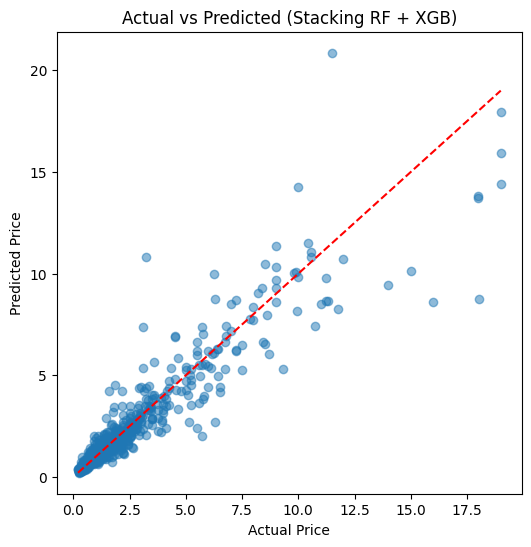

In [31]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import category_encoders as ce
import numpy as np
import matplotlib.pyplot as plt

# ====================================
# 1️⃣ Train-test split
# ====================================
X_train, X_test, y_train, y_test = train_test_split(X, np.log1p(y), test_size=0.2, random_state=42)

# ====================================
# 2️⃣ Preprocessing pipeline
# ====================================
columns_to_encode = ['property_type', 'sector', 'balcony', 'furnishing_type', 'luxury_category', 'floor_category']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['bedRoom', 'bathroom', 'built_up_area', 'servant room', 'store room']),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), 
         ['property_type', 'balcony', 'furnishing_type', 'luxury_category', 'floor_category']),
        ('target_enc', ce.TargetEncoder(), ['sector'])
    ],
    remainder='drop'
)

# ====================================
# 3️⃣ Base Models (your tuned params)
# ====================================
rf_best = RandomForestRegressor(
    n_estimators=454,
    max_depth=39,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features=None,
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)

xgb_best = XGBRegressor(
    n_estimators=791,
    learning_rate=0.0266,
    max_depth=7,
    subsample=0.9518,
    colsample_bytree=0.7703,
    gamma=0.0092,
    reg_alpha=1.108,
    reg_lambda=1.474,
    min_child_weight=4,
    objective='reg:squarederror',
    tree_method='hist',
    random_state=42,
    n_jobs=-1
)

# ====================================
# 4️⃣ Stacking Model
# ====================================
stack_model = StackingRegressor(
    estimators=[
        ('rf', rf_best),
        ('xgb', xgb_best)
    ],
    final_estimator=Ridge(alpha=1.0),
    n_jobs=-1,
    passthrough=True   # Allow meta-model to see original features too
)

# ====================================
# 5️⃣ Full Pipeline
# ====================================
stack_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('stack', stack_model)
])

# ====================================
# 6️⃣ Train & Evaluate
# ====================================
stack_pipeline.fit(X_train, y_train)
y_pred = stack_pipeline.predict(X_test)

# Inverse transform predictions
y_test_exp = np.expm1(y_test)
y_pred_exp = np.expm1(y_pred)

r2 = r2_score(y_test_exp, y_pred_exp)
rmse = np.sqrt(mean_squared_error(y_test_exp, y_pred_exp))
mae = mean_absolute_error(y_test_exp, y_pred_exp)

print("🏆 STACKING MODEL PERFORMANCE")
print(f"R² Score : {r2:.4f}")
print(f"RMSE     : {rmse:.4f}")
print(f"MAE      : {mae:.4f}")

# ====================================
# 7️⃣ Visualization
# ====================================
plt.figure(figsize=(6,6))
plt.scatter(y_test_exp, y_pred_exp, alpha=0.5)
plt.plot([y_test_exp.min(), y_test_exp.max()],
         [y_test_exp.min(), y_test_exp.max()],
         'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted (Stacking RF + XGB)")
plt.show()


In [46]:
# =============================================
#     COMPLETE PIPELINE: ENCODING + ENSEMBLES
# =============================================

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict, train_test_split
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from xgboost import XGBRegressor
import category_encoders as ce

# ===========================================
# 1️⃣ Load and prepare data
# ===========================================
# Assuming you already have your dataframe loaded as df
# df = pd.read_csv("your_dataset.csv")

X = df.drop(columns=['price'])
y = df['price']
y_transformed = np.log1p(y)

# ===========================================
# 2️⃣ Preprocessing setup (your encoding logic)
# ===========================================
columns_to_encode = ['property_type', 'sector', 'balcony', 'agePossession',
                     'furnishing_type', 'luxury_category', 'floor_category']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['bedRoom', 'bathroom', 'built_up_area', 'servant room', 'store room']),
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
         ['property_type', 'sector', 'balcony', 'agePossession', 'furnishing_type', 'luxury_category', 'floor_category']),
        ('cat1', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), ['agePossession']),
        ('target_enc', ce.TargetEncoder(), ['sector'])
    ],
    remainder='passthrough'
)


# ===========================================
# 3️⃣ Define best hyperparameters
# ===========================================
best_rf_params = {
    'n_estimators': 454,
    'max_depth': 39,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_features': None,
    'bootstrap': True,
    'random_state': 42
}

best_xgb_params = {
    'n_estimators': 791,
    'learning_rate': 0.0266,
    'max_depth': 7,
    'subsample': 0.9518,
    'colsample_bytree': 0.7703,
    'gamma': 0.00923,
    'reg_alpha': 1.108,
    'reg_lambda': 1.4735,
    'min_child_weight': 4,
    'random_state': 42
}

rf = RandomForestRegressor(**best_rf_params)
xgb = XGBRegressor(**best_xgb_params)
ridge = Ridge(alpha=1.0)

kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# ===========================================
# 4️⃣ Weighted Averaging
# ===========================================
pipe_rf = Pipeline([('preprocessor', preprocessor), ('model', rf)])
pipe_xgb = Pipeline([('preprocessor', preprocessor), ('model', xgb)])

rf_pred = cross_val_predict(pipe_rf, X, y_transformed, cv=kfold, n_jobs=-1)
xgb_pred = cross_val_predict(pipe_xgb, X, y_transformed, cv=kfold, n_jobs=-1)

final_pred = 0.5 * rf_pred + 0.5 * xgb_pred
weighted_r2 = r2_score(y_transformed, final_pred)
print(f"Weighted Average R²: {weighted_r2:.4f}")

# ===========================================
# 5️⃣ Improved Stacking
# ===========================================
estimators = [
    ('rf', Pipeline([('preprocessor', preprocessor), ('model', rf)])),
    ('xgb', Pipeline([('preprocessor', preprocessor), ('model', xgb)])),
    ('ridge', Pipeline([('preprocessor', preprocessor), ('model', ridge)]))
]

stack = StackingRegressor(
    estimators=estimators,
    final_estimator=XGBRegressor(
        n_estimators=400, learning_rate=0.05, max_depth=4,
        subsample=0.8, colsample_bytree=0.8, random_state=42
    ),
    passthrough=True,
    n_jobs=-1
)

stack_r2 = np.mean(cross_val_score(stack, X, y_transformed, cv=kfold, scoring='r2', n_jobs=-1))
print(f"Improved Stacking R²: {stack_r2:.4f}")

# ===========================================
# 6️⃣ Blending
# ===========================================
# Split the data
X_train, X_blend, y_train, y_blend = train_test_split(X, y_transformed, test_size=0.2, random_state=42)

# Fit preprocessors and models
X_train_prep = preprocessor.fit_transform(X_train)
X_blend_prep = preprocessor.transform(X_blend)

rf.fit(X_train_prep, y_train)
xgb.fit(X_train_prep, y_train)
ridge.fit(X_train_prep, y_train)

# Create blend features
blend_features = np.column_stack([
    rf.predict(X_blend_prep),
    xgb.predict(X_blend_prep),
    ridge.predict(X_blend_prep)
])

meta_model = XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=4, random_state=42)
meta_model.fit(blend_features, y_blend)

blend_pred = meta_model.predict(blend_features)
blend_r2 = r2_score(y_blend, blend_pred)
print(f"Blending R²: {blend_r2:.4f}")

# ===========================================
# 7️⃣ Compare all results
# ===========================================
print("\n🏁 Model Comparison Summary:")
print(f"Weighted Averaging R²: {weighted_r2:.4f}")
print(f"Improved Stacking R²:  {stack_r2:.4f}")
print(f"Blending R²:           {blend_r2:.4f}")

best_score = max(weighted_r2, stack_r2, blend_r2)
if best_score == weighted_r2:
    print("\n🏆 Best Method: Weighted Averaging")
elif best_score == stack_r2:
    print("\n🏆 Best Method: Improved Stacking")
else:
    print("\n🏆 Best Method: Blending")


Weighted Average R²: 0.9071


ValueError: 
All the 10 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "d:\Real-Estate-Insights-Platform\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\Real-Estate-Insights-Platform\.venv\Lib\site-packages\sklearn\ensemble\_stacking.py", line 1043, in fit
    return super().fit(X, y, **fit_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\Real-Estate-Insights-Platform\.venv\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\Real-Estate-Insights-Platform\.venv\Lib\site-packages\sklearn\ensemble\_stacking.py", line 277, in fit
    _fit_single_estimator(self.final_estimator_, X_meta, y, fit_params=fit_params)
  File "d:\Real-Estate-Insights-Platform\.venv\Lib\site-packages\sklearn\ensemble\_base.py", line 39, in _fit_single_estimator
    estimator.fit(X, y, **fit_params)
  File "d:\Real-Estate-Insights-Platform\.venv\Lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "d:\Real-Estate-Insights-Platform\.venv\Lib\site-packages\xgboost\sklearn.py", line 1222, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\Real-Estate-Insights-Platform\.venv\Lib\site-packages\xgboost\sklearn.py", line 628, in _wrap_evaluation_matrices
    train_dmatrix = create_dmatrix(
                    ^^^^^^^^^^^^^^^
  File "d:\Real-Estate-Insights-Platform\.venv\Lib\site-packages\xgboost\sklearn.py", line 1137, in _create_dmatrix
    return QuantileDMatrix(
           ^^^^^^^^^^^^^^^^
  File "d:\Real-Estate-Insights-Platform\.venv\Lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "d:\Real-Estate-Insights-Platform\.venv\Lib\site-packages\xgboost\core.py", line 1614, in __init__
    self._init(
  File "d:\Real-Estate-Insights-Platform\.venv\Lib\site-packages\xgboost\core.py", line 1678, in _init
    it.reraise()
  File "d:\Real-Estate-Insights-Platform\.venv\Lib\site-packages\xgboost\core.py", line 572, in reraise
    raise exc  # pylint: disable=raising-bad-type
    ^^^^^^^^^
  File "d:\Real-Estate-Insights-Platform\.venv\Lib\site-packages\xgboost\core.py", line 553, in _handle_exception
    return fn()
           ^^^^
  File "d:\Real-Estate-Insights-Platform\.venv\Lib\site-packages\xgboost\core.py", line 640, in <lambda>
    return self._handle_exception(lambda: int(self.next(input_data)), 0)
                                              ^^^^^^^^^^^^^^^^^^^^^
  File "d:\Real-Estate-Insights-Platform\.venv\Lib\site-packages\xgboost\data.py", line 1654, in next
    input_data(**self.kwargs)
  File "d:\Real-Estate-Insights-Platform\.venv\Lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "d:\Real-Estate-Insights-Platform\.venv\Lib\site-packages\xgboost\core.py", line 620, in input_data
    new, cat_codes, feature_names, feature_types = _proxy_transform(
                                                   ^^^^^^^^^^^^^^^^^
  File "d:\Real-Estate-Insights-Platform\.venv\Lib\site-packages\xgboost\data.py", line 1681, in _proxy_transform
    data, _ = _ensure_np_dtype(data, data.dtype)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\Real-Estate-Insights-Platform\.venv\Lib\site-packages\xgboost\data.py", line 239, in _ensure_np_dtype
    data = data.astype(dtype, copy=False)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: could not convert string to float: 'flat'


In [47]:


import numpy as np
import pandas as pd
import optuna
from optuna.samplers import TPESampler

from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_val_predict, train_test_split
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import category_encoders as ce

# =========================
# 1) Load & prepare data
# =========================
df = pd.read_csv('../../Dataset/gurgaon_properties_post_feature_selection_v2.csv')

# clean up furnishing types
df['furnishing_type'] = df['furnishing_type'].replace({0.0:'unfurnished',1.0:'semifurnished',2.0:'furnished'})

X = df.drop(columns=['price'])
y = df['price']
y_transformed = np.log1p(y)  # we’ll optimize/evaluate in log-space to match your pipeline

# =========================
# 2) Preprocessor (same as yours)
# =========================
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['bedRoom', 'bathroom', 'built_up_area', 'servant room', 'store room']),
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
         ['property_type', 'sector', 'balcony', 'agePossession', 'furnishing_type', 'luxury_category', 'floor_category']),
        ('cat1', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), ['agePossession']),
        ('target_enc', ce.TargetEncoder(), ['sector'])
    ],
    remainder='passthrough'
)

# =========================
# 3) Base models (your tuned params)
# =========================
best_rf_params = {
    'n_estimators': 454,
    'max_depth': 39,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_features': None,
    'bootstrap': True,
    'random_state': 42
}
best_xgb_params = {
    'n_estimators': 791,
    'learning_rate': 0.0266,
    'max_depth': 7,
    'subsample': 0.9518,
    'colsample_bytree': 0.7703,
    'gamma': 0.00923,
    'reg_alpha': 1.108,
    'reg_lambda': 1.4735,
    'min_child_weight': 4,
    'random_state': 42
}

rf = RandomForestRegressor(**best_rf_params)
xgb = XGBRegressor(**best_xgb_params)
ridge = Ridge(alpha=1.0)

pipe_rf = Pipeline([('preprocessor', preprocessor), ('model', rf)])
pipe_xgb = Pipeline([('preprocessor', preprocessor), ('model', xgb)])
pipe_ridge = Pipeline([('preprocessor', preprocessor), ('model', ridge)])

# Choose which models to blend
base_models = [
    ('rf', pipe_rf),
    ('xgb', pipe_xgb),
    # ('ridge', pipe_ridge),  # <- optionally include ridge in the blend
]

# =========================
# 4) Out-of-fold predictions
# =========================
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

oof_preds = []
model_names = []
for name, pipe in base_models:
    print(f"Computing OOF predictions for: {name}")
    preds = cross_val_predict(pipe, X, y_transformed, cv=kfold, n_jobs=-1)
    oof_preds.append(preds)
    model_names.append(name)

oof_matrix = np.column_stack(oof_preds)  # shape: (n_samples, n_models)

# Baseline (equal weights) for reference
equal_weights = np.ones(oof_matrix.shape[1]) / oof_matrix.shape[1]
baseline_pred = oof_matrix @ equal_weights
baseline_r2 = r2_score(y_transformed, baseline_pred)
print(f"\nEqual-weights OOF R²: {baseline_r2:.4f}")

# =========================
# 5) Optuna to find best weights
#    - Non-negative weights, sum to 1 (softmax/normalization)
# =========================
def objective(trial):
    # suggest one weight per model
    raw_w = np.array([trial.suggest_float(f"w_{i}", 0.0, 1.0) for i in range(oof_matrix.shape[1])])
    # enforce non-negativity and sum-to-one
    if raw_w.sum() == 0:
        raw_w += 1e-8
    w = raw_w / raw_w.sum()

    pred = oof_matrix @ w
    score = r2_score(y_transformed, pred)
    return score

study = optuna.create_study(direction="maximize", sampler=TPESampler(seed=42))
study.optimize(objective, n_trials=200, show_progress_bar=False)

best_raw_weights = np.array([study.best_trial.params[f"w_{i}"] for i in range(oof_matrix.shape[1])])
best_weights = best_raw_weights / best_raw_weights.sum()
best_pred = oof_matrix @ best_weights
best_r2 = r2_score(y_transformed, best_pred)

print("\n🎯 Optimized weights (sum to 1):")
for name, w in zip(model_names, best_weights):
    print(f"  {name}: {w:.4f}")
print(f"Optimized OOF R²: {best_r2:.4f} (vs equal-weights {baseline_r2:.4f})")

# =========================
# 6) Fit final models on full data and define predictor
# =========================
fitted_models = {}
for name, pipe in base_models:
    print(f"Fitting final model on full data: {name}")
    pipe.fit(X, y_transformed)
    fitted_models[name] = pipe

def predict_log_price(X_new):
    # weighted predictions in log-space
    preds = []
    for (name, _), w in zip(base_models, best_weights):
        preds.append(w * fitted_models[name].predict(X_new))
    return np.sum(preds, axis=0)

def predict_price(X_new):
    # convert back to original price scale
    return np.expm1(predict_log_price(X_new))

# =========================
# 7) Optional: hold-out check (to estimate generalization)
# =========================
# If you want an honest estimate, learn weights on train only (OOF on train), then evaluate on test
X_train, X_test, y_train, y_test = train_test_split(X, y_transformed, test_size=0.2, random_state=42)

# Recompute OOF on train only
oof_preds_train = []
for name, pipe in base_models:
    preds = cross_val_predict(pipe, X_train, y_train, cv=kfold, n_jobs=-1)
    oof_preds_train.append(preds)
oof_train_mat = np.column_stack(oof_preds_train)

def holdout_objective(trial):
    raw_w = np.array([trial.suggest_float(f"w_{i}", 0.0, 1.0) for i in range(oof_train_mat.shape[1])])
    if raw_w.sum() == 0:
        raw_w += 1e-8
    w = raw_w / raw_w.sum()
    pred = oof_train_mat @ w
    return r2_score(y_train, pred)

study_holdout = optuna.create_study(direction="maximize", sampler=TPESampler(seed=42))
study_holdout.optimize(holdout_objective, n_trials=150, show_progress_bar=False)
w_train = np.array([study_holdout.best_trial.params[f"w_{i}"] for i in range(oof_train_mat.shape[1])])
w_train = w_train / w_train.sum()

# Fit models on train set only, evaluate on test
fitted_train_models = {}
for name, pipe in base_models:
    fitted_pipe = Pipeline(pipe.steps)  # fresh clone-ish
    fitted_pipe.fit(X_train, y_train)
    fitted_train_models[name] = fitted_pipe

def predict_log_price_holdout(X_new):
    preds = []
    for (name, _), w in zip(base_models, w_train):
        preds.append(w * fitted_train_models[name].predict(X_new))
    return np.sum(preds, axis=0)

y_test_pred = predict_log_price_holdout(X_test)
holdout_r2 = r2_score(y_test, y_test_pred)
print(f"\nHold-out R² (weights learned on train via OOF): {holdout_r2:.4f}")

# Example: predict on full X in original scale
# preds_price = predict_price(X)
# print(preds_price[:5])

Computing OOF predictions for: rf
Computing OOF predictions for: xgb


[I 2025-10-08 15:00:09,348] A new study created in memory with name: no-name-2db9730f-9224-41b1-ad01-1db6a7c6036d
[I 2025-10-08 15:00:09,348] Trial 0 finished with value: 0.9067239027553384 and parameters: {'w_0': 0.3745401188473625, 'w_1': 0.9507143064099162}. Best is trial 0 with value: 0.9067239027553384.
[I 2025-10-08 15:00:09,348] Trial 1 finished with value: 0.9070012533529292 and parameters: {'w_0': 0.7319939418114051, 'w_1': 0.5986584841970366}. Best is trial 1 with value: 0.9070012533529292.
[I 2025-10-08 15:00:09,357] Trial 2 finished with value: 0.9071081258557276 and parameters: {'w_0': 0.15601864044243652, 'w_1': 0.15599452033620265}. Best is trial 2 with value: 0.9071081258557276.
[I 2025-10-08 15:00:09,359] Trial 3 finished with value: 0.9049338836975145 and parameters: {'w_0': 0.05808361216819946, 'w_1': 0.8661761457749352}. Best is trial 2 with value: 0.9071081258557276.
[I 2025-10-08 15:00:09,362] Trial 4 finished with value: 0.9071411636772846 and parameters: {'w_0':


Equal-weights OOF R²: 0.9071


[I 2025-10-08 15:00:09,544] Trial 24 finished with value: 0.906988388839516 and parameters: {'w_0': 0.8225247923552409, 'w_1': 0.6608557252922864}. Best is trial 11 with value: 0.9071419248092243.
[I 2025-10-08 15:00:09,552] Trial 25 finished with value: 0.9071222939273947 and parameters: {'w_0': 0.49845064179653653, 'w_1': 0.521732800059271}. Best is trial 11 with value: 0.9071419248092243.
[I 2025-10-08 15:00:09,557] Trial 26 finished with value: 0.9071209346263815 and parameters: {'w_0': 0.6484881796319708, 'w_1': 0.918055126685164}. Best is trial 11 with value: 0.9071419248092243.
[I 2025-10-08 15:00:09,565] Trial 27 finished with value: 0.9071113365512182 and parameters: {'w_0': 0.7751024595894629, 'w_1': 0.782280212271333}. Best is trial 11 with value: 0.9071419248092243.
[I 2025-10-08 15:00:09,580] Trial 28 finished with value: 0.9068866754327705 and parameters: {'w_0': 0.5757662941374543, 'w_1': 0.40983120037328424}. Best is trial 11 with value: 0.9071419248092243.
[I 2025-10-0


🎯 Optimized weights (sum to 1):
  rf: 0.4519
  xgb: 0.5481
Optimized OOF R²: 0.9071 (vs equal-weights 0.9071)
Fitting final model on full data: rf
Fitting final model on full data: xgb


[I 2025-10-08 15:00:28,684] A new study created in memory with name: no-name-5c24c9fb-3788-4961-ae04-f22d8879187d
[I 2025-10-08 15:00:28,684] Trial 0 finished with value: 0.9004730426409286 and parameters: {'w_0': 0.3745401188473625, 'w_1': 0.9507143064099162}. Best is trial 0 with value: 0.9004730426409286.
[I 2025-10-08 15:00:28,689] Trial 1 finished with value: 0.8993352925100169 and parameters: {'w_0': 0.7319939418114051, 'w_1': 0.5986584841970366}. Best is trial 0 with value: 0.9004730426409286.
[I 2025-10-08 15:00:28,689] Trial 2 finished with value: 0.8997142276830608 and parameters: {'w_0': 0.15601864044243652, 'w_1': 0.15599452033620265}. Best is trial 0 with value: 0.9004730426409286.
[I 2025-10-08 15:00:28,689] Trial 3 finished with value: 0.8997747916483505 and parameters: {'w_0': 0.05808361216819946, 'w_1': 0.8661761457749352}. Best is trial 0 with value: 0.9004730426409286.
[I 2025-10-08 15:00:28,689] Trial 4 finished with value: 0.8999670021545934 and parameters: {'w_0':


Hold-out R² (weights learned on train via OOF): 0.9200


In [48]:
# after building oof_matrix as in your code
import numpy as np
corr = np.corrcoef(oof_matrix.T)
print("OOF prediction correlation matrix:\n", np.round(corr, 4))

OOF prediction correlation matrix:
 [[1.     0.9918]
 [0.9918 1.    ]]


In [49]:
# oof_matrix: (n_samples, 2) with columns [rf_pred, xgb_pred]
p1 = oof_matrix[:, 0]  # rf
p2 = oof_matrix[:, 1]  # xgb
y_ = y_transformed.values if hasattr(y_transformed, 'values') else y_transformed

num = np.dot(y_ - p2, p1 - p2)
den = np.dot(p1 - p2, p1 - p2) + 1e-12
w_rf = np.clip(num / den, 0, 1)
w_xgb = 1 - w_rf
print(f"Analytic convex weights -> rf: {w_rf:.4f}, xgb: {w_xgb:.4f}")

Analytic convex weights -> rf: 0.4519, xgb: 0.5481


In [53]:
from sklearn.metrics import mean_squared_error
import numpy as np

# MSE/RMSE in log space
mse_log = mean_squared_error(y_transformed, best_pred)
print(f"OOF MSE (log): {mse_log:.6f}")

# MSE/RMSE on original price scale
y_true_price = np.expm1(y_transformed)
y_pred_price = np.expm1(best_pred)
mse_price = mean_squared_error(y_true_price, y_pred_price)

print(f"OOF MSE (price): {mse_price:,.2f}")

OOF MSE (log): 0.028901
OOF MSE (price): 1.25
